## Tutorial: Building a problem and data retriever from scratch


In this tutorial, we will build a new optimization problem (which is not present in the examples provided in the toolbox), to show how the classes related to the optimization problem and its data retriever should be set up.

The problem we consider is the spherically constrained quadratic problem (SCQP):

$\text{min}_X\; 0.5\cdot\mathbb{E}[||X^T\mathbf{y}(t)||^2]+\text{trace}(X^TB)$
$\text{s.t. } \text{trace}(X^TX)=1.$


In [1]:
import numpy as np

from dasftoolbox import (
    OptimizationProblem,
    DataRetriever,
    DataWindowParameters,
    ProblemInputs,
    NetworkGraph,
    ConvergenceParameters,
    DASF,
)
from dasftoolbox.utils import autocorrelation_matrix, make_symmetric, normalize

import pymanopt
from pymanopt.manifolds import Sphere
from pymanopt import Problem
from pymanopt.optimizers import TrustRegions
import autograd

import matplotlib.pyplot as plt


Note that the constraint of the problem corresponds to a sphere, for which a manifold optimization method can be applied. Therefore, we will use the `pymanopt` library (https://pymanopt.org) to solve the SCQP problem with a trust regions solver.

We build the **`SCQPProblem`** class as follows:

- We make it a child class of **`OptimizationProblem`** such that all attributes and methods are inherited.
- The initialization requires the number of filters (or number of columns of `X`), other attributes are optional.
- The solver is implemented inside the **`solve`** method, for which the problem inputs of class **`ProblemInputs`** must be provided.
- The **`evaluate_objective`** method is used for evaluating the objective at a given `X` and for given inputs.
- In the case of the SCQP, we do not need to provide a **`resolve_ambiguity`** function, as the solution is unique.

An implementation is provided below:


In [2]:
class SCQPProblem(OptimizationProblem):
    """
    SCQP problem class.

    :math:`\min_X\; \\frac{1}{2}\mathbb{E}[\| X^T \mathbf{y}(t)\|^2] + \\text{trace}(X^T B)` subject to :math:`\\text{trace}(X^T \Gamma  X) = 1.`

    Attributes
    ----------
    nb_filters : int
        Number of filters.
    """

    def __init__(self, nb_filters: int, **kwargs) -> None:
        super().__init__(nb_filters=nb_filters, **kwargs)

    def solve(
        self,
        problem_inputs: ProblemInputs,
        save_solution: bool = False,
        convergence_parameters=None,
        initial_estimate=None,
    ) -> np.ndarray:
        """
        Solve the SCQP problem.

        The solver uses the `pymanopt` package for optimization on manifolds.

        Parameters
        ----------
        problem_inputs : ProblemInputs
            The problem inputs containing the observed signal :math:`\mathbf{y}` and the matrices :math:`B` and :math:`\Gamma`.
        save_solution : bool, optional
            Whether to save the solution or not, by default False
        convergence_parameters : ConvergenceParameters | None, optional
            Convergence parameters, by default None
        initial_estimate : np.ndarray | None, optional
            Initial estimate, by default None

        Returns
        -------
        np.ndarray
            The solution to the SCQP problem.
        """
        Y = problem_inputs.fused_signals[0]
        B = problem_inputs.fused_constants[0]
        Gamma = problem_inputs.fused_quadratics[0]

        manifold = Sphere(np.size(B, 0), np.size(B, 1))

        Ryy = autocorrelation_matrix(Y)

        Gamma = make_symmetric(Gamma)

        L = np.linalg.cholesky(Gamma)
        Ryy_t = np.linalg.inv(L) @ Ryy @ np.linalg.inv(L).T
        Ryy_t = make_symmetric(Ryy_t)
        B_t = np.linalg.inv(L) @ B

        @pymanopt.function.autograd(manifold)
        def cost(X):
            return 0.5 * autograd.numpy.trace(X.T @ Ryy_t @ X) + autograd.numpy.trace(
                X.T @ B_t
            )

        problem = Problem(manifold=manifold, cost=cost)
        problem.verbosity = 0

        solver = TrustRegions(verbosity=0)
        X_star = solver.run(problem).point
        X_star = np.linalg.inv(L.T) @ X_star

        if save_solution:
            self._X_star = X_star

        return X_star

    def evaluate_objective(self, X: np.ndarray, problem_inputs: ProblemInputs) -> float:
        """
        Evaluate the SCQP objective :math:`\\frac{1}{2}\mathbb{E}[\| X^T \mathbf{y}(t)\|^2] + \\text{trace}(X^T B)`.
        """
        Y = problem_inputs.fused_signals[0]
        B = problem_inputs.fused_constants[0]

        Ryy = autocorrelation_matrix(Y)

        f = 0.5 * np.trace(X.T @ Ryy @ X) + np.trace(X.T @ B)

        return f

The next step is to create a data retriever using a class that inherits the **`DataRetriever`** class. Here, we will again use a synthetic dataset that will be constructed inside the **`SCQPDataRetriever`** class. Note that the data retriever's only purpose is to return a window of data, so in cases where a real dataset is used, there is no need to create artificial data, making the functions inside the retriever much smaller than the example we provide, since here we implement the data generation from scratch.

The data retriever should be provided an instance of **`DataWindowParameters`** which will be used to return the correct window of data.


In [3]:
class SCQPDataRetriever(DataRetriever):
    """
    SCQP data retriever class.

    Simulates a setting where noisy mixture of sources are observed by the nodes of the network.

    Formally, the signals generated are given by :math:`\mathbf{y}(t)=A(t)\cdot\mathbf{d}(t)+\mathbf{n}(t)`, where :math:`\mathbf{d}\in\mathbb{R}^L` corresponds to the source signal, :math:`\mathbf{n}\in\mathbb{R}^M` to the noise and :math:`A\in\mathbb{R}^{M\times L}` to the mixture matrix. The non-stationarity of :math:`\mathbf{y}` follows from the dependence of :math:`A` on time, where :math:`A(t)=A_0+\Delta\cdot w(t)`, with :math:`w` representing a weight function varying in time.

    The signal :math:`\mathbf{y}` is normalized to have unit norm and zero mean.


    Attributes
    ----------
    data_window_params : DataWindowParameters
        Class instance storing the parameters that define a window of data.
    nb_sensors : int
        Number of sensors in the network. Equals to :math:`M`, the dimension of :math:`\mathbf{y}`.
    nb_sources : int
        Number of sources. Represents the number of true number of sources that generate the data. Equals to :math:`L`, the dimension of :math:`\mathbf{d}`.
    nb_windows : int
        Number of windows of data.
    nb_filters : int
        Number of filters, i.e., number of columns :math:`Q` of :math:`X`.
    rng : np.random.Generator
        Random number generator for reproducibility.
    signal_var : float
        Variance of the signals of interest, i.e., :math:`\mathbf{d}`. By default 0.5.
    noise_var : float
        Variance of the noise, i.e., :math:`\mathbf{n}`. By default 0.1.
    mixture_var : float
        Variance of the elements of mixture matrix :math:`A_0`. By default 0.5.
    diff_var : float
        Norm of :math:`\Delta`. By default 1.
    """

    def __init__(
        self,
        data_window_params: DataWindowParameters,
        nb_sensors: int,
        nb_sources: int,
        nb_windows: int,
        nb_filters: int,
        rng: np.random.Generator,
        signal_var: float = 0.5,
        noise_var: float = 0.1,
        mixture_var: float = 0.5,
        diff_var: float = 1,
    ) -> None:
        self.data_window_params = data_window_params
        nb_samples = data_window_params.window_length
        self.nb_sensors = nb_sensors
        self.D = rng.normal(
            loc=0,
            scale=np.sqrt(signal_var),
            size=(nb_sources, nb_samples),
        )
        self.A_0 = rng.normal(
            loc=0, scale=np.sqrt(mixture_var), size=(nb_sensors, nb_sources)
        )
        self.Delta = rng.normal(
            loc=0, scale=np.sqrt(mixture_var), size=(nb_sensors, nb_sources)
        )
        self.Delta = (
            self.Delta
            * np.linalg.norm(self.A_0, "fro")
            * diff_var
            / np.linalg.norm(self.Delta, "fro")
        )
        self.noise = rng.normal(
            loc=0,
            scale=np.sqrt(noise_var),
            size=(nb_sensors, nb_samples),
        )
        self.B = rng.normal(loc=0, scale=1, size=(nb_sensors, nb_filters))

        self.weights = self.weight_function(nb_windows)

    def get_data_window(self, window_id: int) -> ProblemInputs:
        Y_window = (
            self.A_0 + self.Delta * self.weights[window_id]
        ) @ self.D + self.noise
        Y_window = normalize(Y_window)
        scqp_inputs = ProblemInputs(
            fused_signals=[Y_window],
            fused_constants=[self.B],
            fused_quadratics=[np.eye(self.nb_sensors)],
        )
        return scqp_inputs

    get_data_window.__doc__ = DataRetriever.get_data_window.__doc__

    def weight_function(self, nb_windows: int) -> np.ndarray:
        """
        Weight function :math:`w` for the non-stationarity of the signals. Here, a piecewise linear function is used.

        Parameters
        ----------
        nb_windows : int
            Number of windows of data.
        """
        if nb_windows < 10:
            weights = np.zeros(nb_windows)
        else:
            segment_1 = np.linspace(0, 1, int(5 * nb_windows / 10), endpoint=False)
            segment_2 = np.linspace(0, 1, int(3 * nb_windows / 10), endpoint=False)
            segment_3 = np.linspace(0, 1, int(2 * nb_windows / 10), endpoint=False)

            weights = np.concatenate([segment_1, segment_2, segment_3])
        return weights


We now set the main parameters of the problem.


In [4]:
random_seed = 2025
rng = np.random.default_rng(random_seed)

# Number of nodes
nb_nodes = 30
# Number of channels per node
nb_sensors_per_node = (15 * np.ones(nb_nodes)).astype(int)
# Create adjacency matrix (hollow matrix) of a random graph
adjacency_matrix = rng.integers(0, 1, size=(nb_nodes, nb_nodes), endpoint=True)
adjacency_matrix = np.triu(adjacency_matrix, 1) + np.tril(adjacency_matrix.T, -1)
network_graph = NetworkGraph(
    nb_nodes=nb_nodes,
    nb_sensors_per_node=nb_sensors_per_node,
    adjacency_matrix=adjacency_matrix,
)

# Number of samples per window of the signals
nb_samples_per_window = 10000

# Number of windows in total
nb_windows = 200

# Number of filters of X
nb_filters = 3

We select a non-stationary setting where every window will be re-used twice (with a sliding offset equal to the window length, so no overlapping windows).


In [5]:
# Number of times each window will be repeated
nb_window_reuse = 2

data_window_params = DataWindowParameters(
    window_length=nb_samples_per_window,
    nb_window_reuse=nb_window_reuse,
)

Then, we create an instance of the data retriever and the SCQP problem as shown below.


In [6]:
nb_sources = 10
scqp_data_retriever = SCQPDataRetriever(
    data_window_params=data_window_params,
    nb_sensors=network_graph.nb_sensors_total,
    nb_sources=nb_sources,
    nb_windows=nb_windows,
    rng=rng,
    nb_filters=nb_filters,
)
scqp_problem = SCQPProblem(nb_filters=nb_filters)

We choose the number of iterations of the DASF algorithm to exactly correspond to the number of windows times the number of times wach window is re-used, and create an instance of the DASF solver.


In [7]:
max_iterations = nb_windows * data_window_params.nb_window_reuse
dasf_convergence_parameters = ConvergenceParameters(max_iterations=max_iterations)

update_path = rng.permutation(range(nb_nodes))

dasf_solver = DASF(
    problem=scqp_problem,
    data_retriever=scqp_data_retriever,
    network_graph=network_graph,
    dasf_convergence_params=dasf_convergence_parameters,
    updating_path=update_path,
    rng=rng,
    dynamic_plot=False,
)

INFO:dasftoolbox.dasf:No convergence parameters provided for the solver, assuming it is not neccessary (e.g., closed form solution).


After running the solver, we can look at the error over different batches, or windows, of data.


In [8]:
dasf_solver.run()

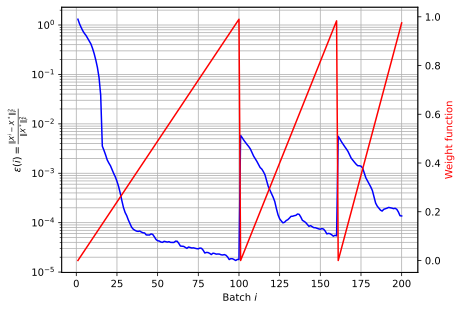

In [9]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

fig = dasf_solver.plot_error_over_batches()
ax = plt.gca()
ax.set_xscale("linear")
ax2 = ax.twinx()
ax2.plot(
    range(
        1,
        int(dasf_solver.total_iterations / data_window_params.nb_window_reuse) + 1,
    ),
    scqp_data_retriever.weight_function(nb_windows),
    "r",
)
ax2.set_ylabel("Weight function", color="r")
plt.show()

Note that there are twice as many iterations as there are windows, since we set the number of re-usage of each window to 2, which can be seen if we look at the error plot with respect to iterations (versus batches).


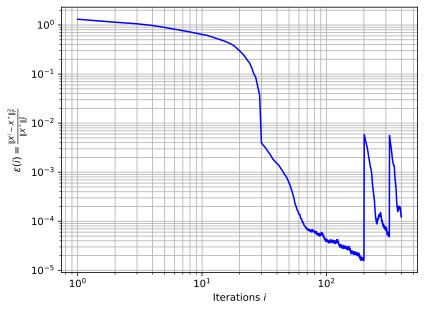

In [10]:
fig = dasf_solver.plot_error()
plt.show()